In [1]:
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import joblib

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

from collections import defaultdict
from contextlib import contextmanager

import time

C:\Users\anson\AppData\Local\Temp\ipykernel_10860\4111777933.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def custom_dataloader(data_dir, transform, batch_size=64, num_workers=1):

  '''
  input:
    data_dir: file path of input data. raw_dataset are created from that file
    batch_size
    num_workers
  output:
    train_loader, val_loader, test_loader
  -----
  data is transformed by data_transform. train:val:test = 0.8:0.1:0.1 with each classes equally splitted
    '''

  raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
  print(raw_dataset)
  num_classes = len(raw_dataset.classes)
  print("Number of classes:", num_classes)
  np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
  indices = np.arange(len(raw_dataset))
  np.random.shuffle(indices)
  train_split = int(len(indices) * 0.8)
  testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
  # split into training and validation indices
  relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                            num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(test_indices)
  test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=test_sampler)
  print(f'data loading completed')
  return train_loader, val_loader, test_loader

In [4]:
unzipped_dir = 'E:/wikiART224'

In [5]:
train_loader, val_loader, test_loader = custom_dataloader(unzipped_dir, transform, batch_size=128)

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


Removed classes without sufficient samples.

In [6]:
used_class = [
    'Abstract_Expressionism',
    'Art_Nouveau_Modern',
    'Baroque',
    'Cubism',
    'Early_Renaissance',
    'Expressionism',
    'High_Renaissance',
    'Impressionism',
    'Mannerism_Late_Renaissance',
    'Minimalism',
    'Naive_Art_Primitivism',
    'Northern_Renaissance',
    'Post_Impressionism',
    'Realism',
    'Rococo',
    'Romanticism',
    'Symbolism',
    'Ukiyo_e'
]

# Model Architecture

In [7]:
class StyleResNet50(nn.Module):
  def __init__(self):
    super(StyleResNet50, self).__init__()
    resnet = models.resnet50(pretrained=True)
        # Freeze all parameters in ResNet
    for param in resnet.parameters():
      param.requires_grad = False
    # Get the number of input features of the last layer in ResNet
    num_features = resnet.fc.in_features
        
    # Remove the last fully connected layer of ResNet
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    
    self.fc1 = nn.Linear(num_features, 19)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)

    return x

In [8]:
class StyleResNet50_1(nn.Module):
  def __init__(self):
    super(StyleResNet50_1, self).__init__()
    resnet = models.resnet50(pretrained=True)
        # Freeze all parameters in ResNet
    for param in resnet.parameters():
      param.requires_grad = False
    # Get the number of input features of the last layer in ResNet
    num_features = resnet.fc.in_features
        
    # Remove the last fully connected layer of ResNet
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    
    self.fc1 = nn.Linear(num_features, 19)
    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc1(x)

    return x

In [9]:
class StyleResNet50_2(nn.Module):
    def __init__(self, num_classes=19, prob=0.5):
        super(StyleResNet50_2, self).__init__()
        resnet = models.resnet50(pretrained=True)
            # Freeze all parameters in ResNet
        for param in resnet.parameters():
            param.requires_grad = False
        # Get the number of input features of the last layer in ResNet
        num_features = resnet.fc.in_features
        # Remove the last fully connected layer of ResNet
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # Add Dropout
        self.dropout = nn.Dropout(prob)
        # Add two fully connected layers with dropout and Leaky ReLU
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [11]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time):
    print(f'elapsed time: {elapsed_time}')
    iterations = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, train_losses, label='Train Loss', color='blue')
    plt.plot(iterations, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    epochs = range(1, len(train_accuracies) + 1)
    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():

        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)
          #pred = (output > 0.0).squeeze().long()
          #total_correct += (pred == labels).sum().item()
          pred = output.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()
          total_samples += data.size(0)

    accuracy = total_correct / total_samples
    average_loss = total_loss / total_samples

    return average_loss, accuracy

In [13]:
def train_model(model, model_name, train_loader, valid_loader, device, num_epochs=4, lr=0.0001, wd=0, clip_gradient=None):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(num_epochs):

        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        tqdm_bar = tqdm(train_loader)

        for batch_idx, (inputs, labels) in enumerate(tqdm_bar):
            with torch.set_grad_enabled(True):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                if clip_gradient is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                pred = outputs.max(1, keepdim=True)[1]
                running_pred += pred.eq(labels.view_as(pred)).sum().item()
                running_total += pred.shape[0]


        train_acc = running_pred / running_total
        train_loss = running_loss / running_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        valid_loss, valid_acc = evaluate_model(model, valid_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')
        model.train()
        
        joblib.dump(model, f'C:\\Users\\anson\\Documents\\Projects\\Python\\AI_Art_Curation_System\\outputs\\{model_name}_epoch{epoch+1}.joblib')

        results = pd.DataFrame({'train loss': train_losses, 'valid loss': valid_losses, 'train accuracy': train_accuracies, 'valid accuracy': valid_accuracies})
        results.to_csv(f'C:\\Users\\anson\\Documents\\Projects\\Python\\AI_Art_Curation_System\\outputs\\{model_name}_results.csv')
    end_time = time.time()
    elapsed_time = end_time - start_time
    plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time)


    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

100%|██████████| 948/948 [03:21<00:00,  4.71it/s]


Epoch [1/3], Step [948/948], Training Loss: 2.2930, Training Accuracy: 0.2671, Validation Loss: 2.0203, Validation Accuracy: 0.3502


100%|██████████| 948/948 [03:15<00:00,  4.84it/s]


Epoch [2/3], Step [948/948], Training Loss: 2.0049, Training Accuracy: 0.3504, Validation Loss: 1.8830, Validation Accuracy: 0.4006


100%|██████████| 948/948 [03:34<00:00,  4.41it/s]


Epoch [3/3], Step [948/948], Training Loss: 1.9203, Training Accuracy: 0.3737, Validation Loss: 1.8201, Validation Accuracy: 0.4092
elapsed time: 697.9665925502777


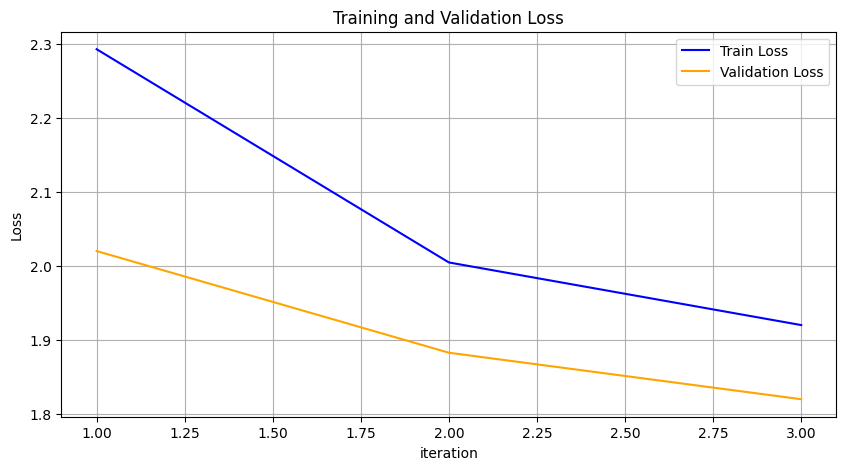

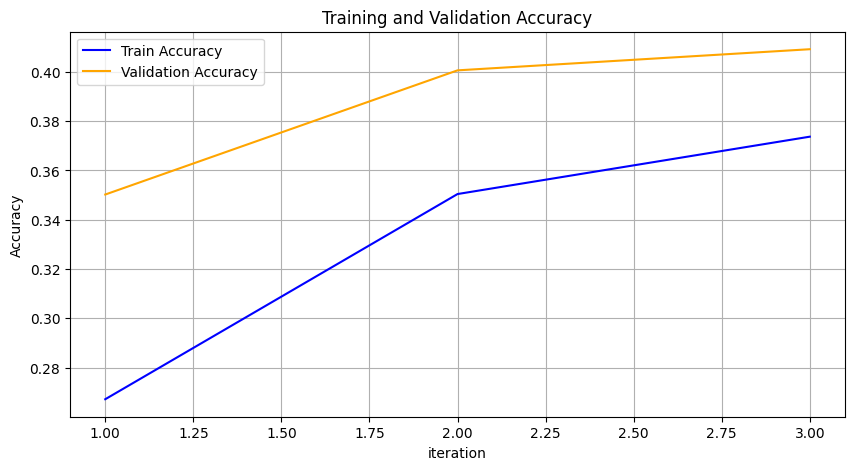

In [22]:
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50', train_loader, val_loader, device, num_epochs = 3, clip_gradient=1.0)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 948/948 [03:35<00:00,  4.40it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.3048, Training Accuracy: 0.2596, Validation Loss: 2.0333, Validation Accuracy: 0.3622


100%|██████████| 948/948 [03:23<00:00,  4.66it/s]


Epoch [2/5], Step [948/948], Training Loss: 2.0120, Training Accuracy: 0.3509, Validation Loss: 1.8911, Validation Accuracy: 0.3965


100%|██████████| 948/948 [03:50<00:00,  4.12it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.9256, Training Accuracy: 0.3722, Validation Loss: 1.8304, Validation Accuracy: 0.4105


100%|██████████| 948/948 [04:12<00:00,  3.76it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.8779, Training Accuracy: 0.3858, Validation Loss: 1.7911, Validation Accuracy: 0.4233


100%|██████████| 948/948 [03:57<00:00,  4.00it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.8527, Training Accuracy: 0.3918, Validation Loss: 1.7631, Validation Accuracy: 0.4314
elapsed time: 1281.8921661376953


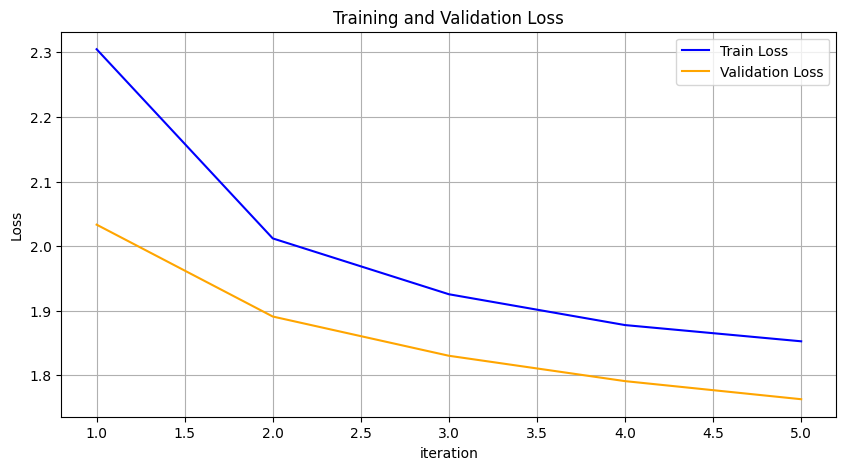

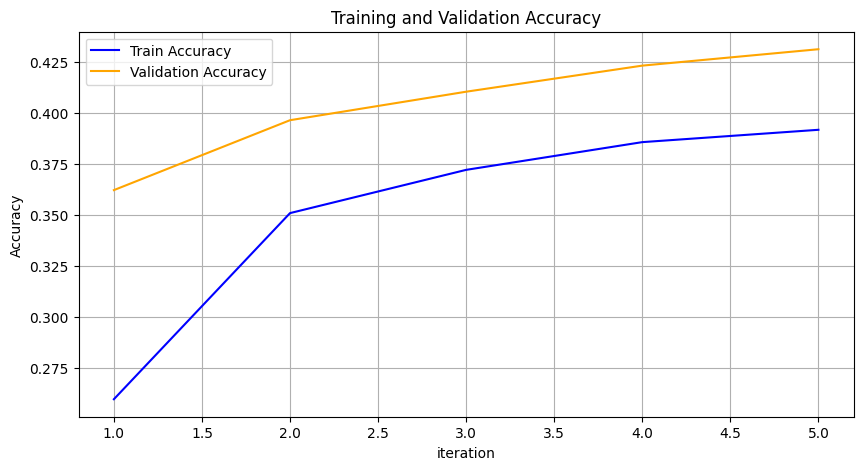

In [23]:
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50', train_loader, val_loader, device, num_epochs = 5, clip_gradient=None)

100%|██████████| 948/948 [04:08<00:00,  3.82it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.0304, Training Accuracy: 0.3403, Validation Loss: 1.7743, Validation Accuracy: 0.4137


100%|██████████| 948/948 [04:02<00:00,  3.91it/s]


Epoch [2/5], Step [948/948], Training Loss: 1.9360, Training Accuracy: 0.3679, Validation Loss: 1.7522, Validation Accuracy: 0.4219


100%|██████████| 948/948 [04:08<00:00,  3.82it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.9366, Training Accuracy: 0.3684, Validation Loss: 1.8084, Validation Accuracy: 0.4099


100%|██████████| 948/948 [03:14<00:00,  4.87it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.9298, Training Accuracy: 0.3735, Validation Loss: 1.7613, Validation Accuracy: 0.4117


100%|██████████| 948/948 [03:08<00:00,  5.02it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.9335, Training Accuracy: 0.3707, Validation Loss: 1.7152, Validation Accuracy: 0.4274
elapsed time: 1272.9721336364746


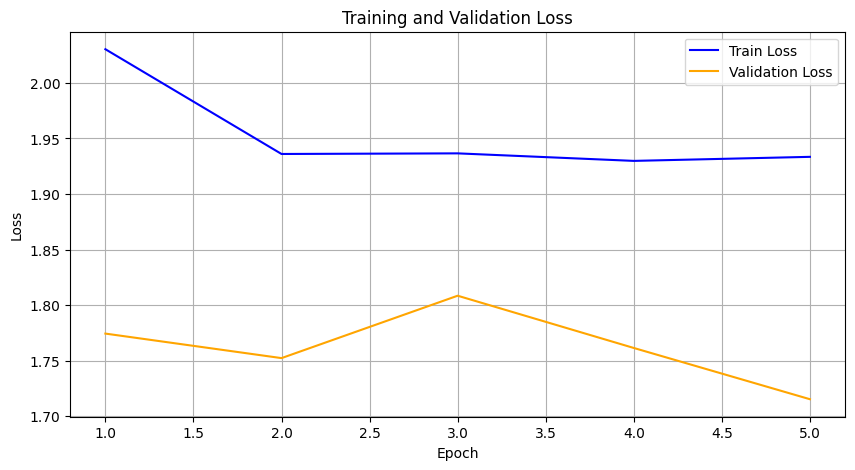

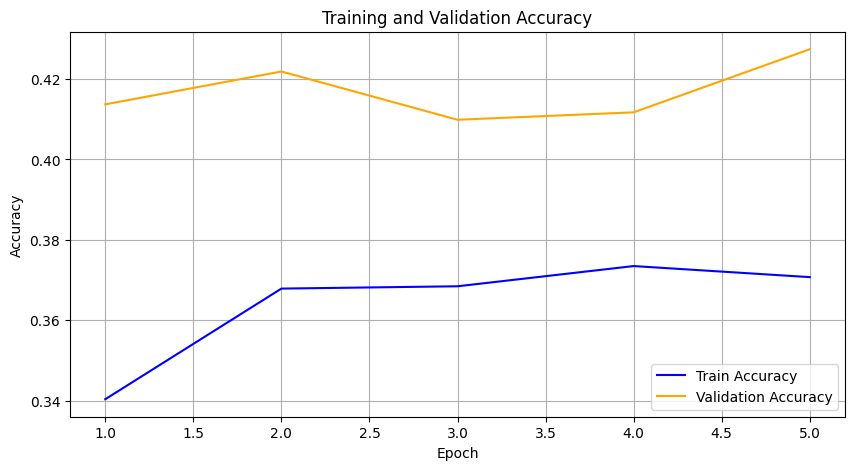

In [26]:
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model_50_lr001', train_loader, val_loader, device,lr=0.001, num_epochs = 5, clip_gradient=None)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 948/948 [04:09<00:00,  3.80it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.2365, Training Accuracy: 0.2845, Validation Loss: 1.9855, Validation Accuracy: 0.3758


100%|██████████| 948/948 [04:14<00:00,  3.73it/s]


Epoch [2/5], Step [948/948], Training Loss: 1.9428, Training Accuracy: 0.3769, Validation Loss: 1.8559, Validation Accuracy: 0.4087


100%|██████████| 948/948 [04:14<00:00,  3.73it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.8570, Training Accuracy: 0.3963, Validation Loss: 1.7980, Validation Accuracy: 0.4162


100%|██████████| 948/948 [03:26<00:00,  4.59it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.8112, Training Accuracy: 0.4068, Validation Loss: 1.7673, Validation Accuracy: 0.4264


100%|██████████| 948/948 [03:15<00:00,  4.85it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.7820, Training Accuracy: 0.4138, Validation Loss: 1.7334, Validation Accuracy: 0.4380
elapsed time: 1307.6794471740723


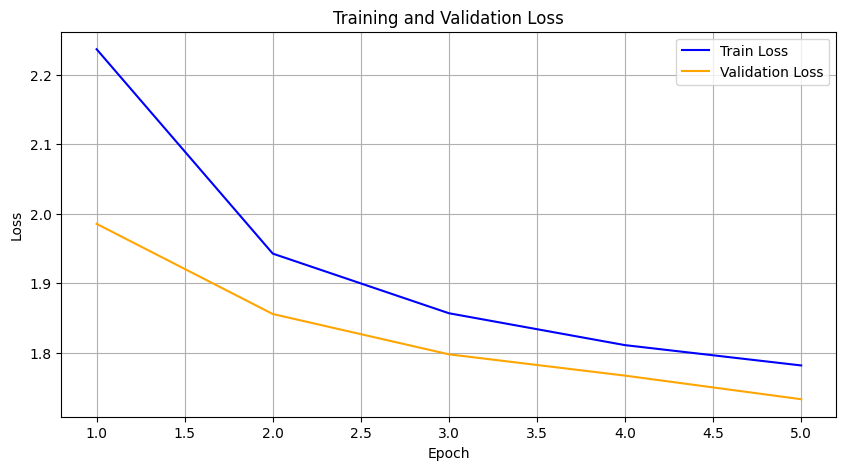

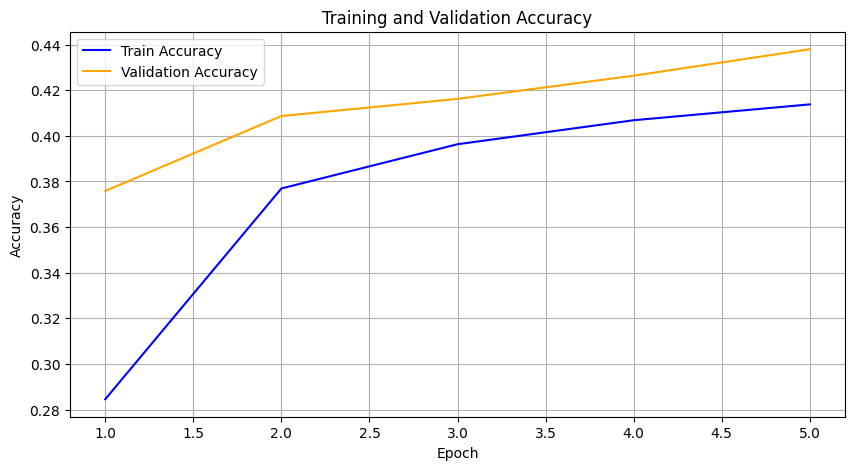

In [68]:
model1 = StyleResNet50_1()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model1, 'model_50_1', train_loader, val_loader, device, num_epochs = 5, clip_gradient=None)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 948/948 [03:45<00:00,  4.20it/s]


Epoch [1/5], Step [948/948], Training Loss: 2.2104, Training Accuracy: 0.2893, Validation Loss: 1.8882, Validation Accuracy: 0.3985


100%|██████████| 948/948 [03:06<00:00,  5.08it/s]


Epoch [2/5], Step [948/948], Training Loss: 1.9594, Training Accuracy: 0.3559, Validation Loss: 1.7915, Validation Accuracy: 0.4179


100%|██████████| 948/948 [03:07<00:00,  5.05it/s]


Epoch [3/5], Step [948/948], Training Loss: 1.8934, Training Accuracy: 0.3752, Validation Loss: 1.7441, Validation Accuracy: 0.4303


100%|██████████| 948/948 [04:04<00:00,  3.87it/s]


Epoch [4/5], Step [948/948], Training Loss: 1.8590, Training Accuracy: 0.3849, Validation Loss: 1.7231, Validation Accuracy: 0.4410


100%|██████████| 948/948 [03:57<00:00,  4.00it/s]


Epoch [5/5], Step [948/948], Training Loss: 1.8382, Training Accuracy: 0.3892, Validation Loss: 1.7038, Validation Accuracy: 0.4437
elapsed time: 1228.6836795806885


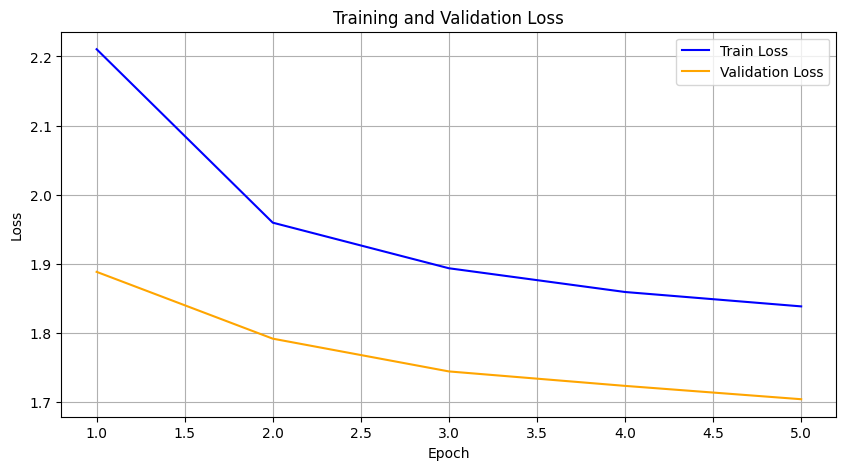

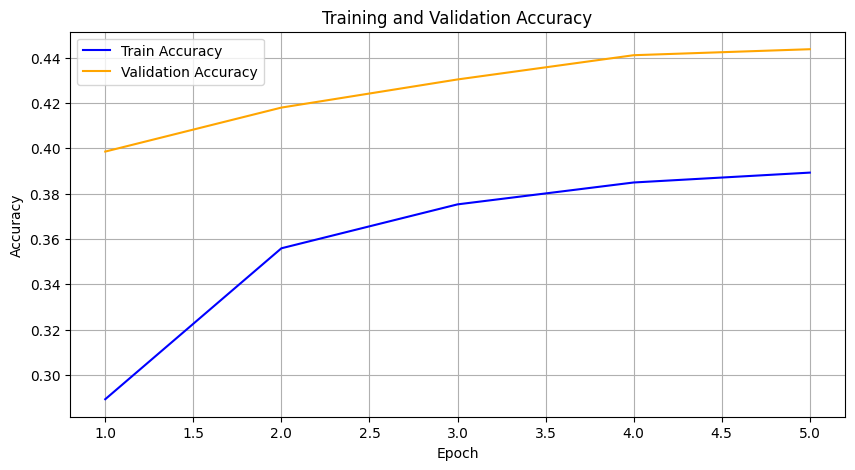

In [17]:
model2 = StyleResNet50_2()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model2, 'model_50_2', train_loader, val_loader, device, num_epochs = 5, clip_gradient=None)

c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 474/474 [03:47<00:00,  2.09it/s]


Epoch [1/10], Step [474/474], Training Loss: 2.0707, Training Accuracy: 0.3376, Validation Loss: 1.8313, Validation Accuracy: 0.4026


100%|██████████| 474/474 [03:42<00:00,  2.13it/s]


Epoch [2/10], Step [474/474], Training Loss: 1.7854, Training Accuracy: 0.4111, Validation Loss: 1.7361, Validation Accuracy: 0.4331


100%|██████████| 474/474 [03:02<00:00,  2.59it/s]


Epoch [3/10], Step [474/474], Training Loss: 1.7191, Training Accuracy: 0.4304, Validation Loss: 1.6946, Validation Accuracy: 0.4356


100%|██████████| 474/474 [03:02<00:00,  2.59it/s]


Epoch [4/10], Step [474/474], Training Loss: 1.6815, Training Accuracy: 0.4401, Validation Loss: 1.6643, Validation Accuracy: 0.4459


100%|██████████| 474/474 [03:34<00:00,  2.21it/s]


Epoch [5/10], Step [474/474], Training Loss: 1.6543, Training Accuracy: 0.4478, Validation Loss: 1.6660, Validation Accuracy: 0.4563


100%|██████████| 474/474 [04:03<00:00,  1.94it/s]


Epoch [6/10], Step [474/474], Training Loss: 1.6313, Training Accuracy: 0.4538, Validation Loss: 1.6358, Validation Accuracy: 0.4583


100%|██████████| 474/474 [03:51<00:00,  2.05it/s]


Epoch [7/10], Step [474/474], Training Loss: 1.6100, Training Accuracy: 0.4606, Validation Loss: 1.6158, Validation Accuracy: 0.4649


100%|██████████| 474/474 [03:10<00:00,  2.49it/s]


Epoch [8/10], Step [474/474], Training Loss: 1.5940, Training Accuracy: 0.4661, Validation Loss: 1.5995, Validation Accuracy: 0.4640


100%|██████████| 474/474 [03:06<00:00,  2.54it/s]


Epoch [9/10], Step [474/474], Training Loss: 1.5740, Training Accuracy: 0.4706, Validation Loss: 1.5855, Validation Accuracy: 0.4703


100%|██████████| 474/474 [04:04<00:00,  1.94it/s]


Epoch [10/10], Step [474/474], Training Loss: 1.5584, Training Accuracy: 0.4766, Validation Loss: 1.5736, Validation Accuracy: 0.4748
elapsed time: 2399.532497406006


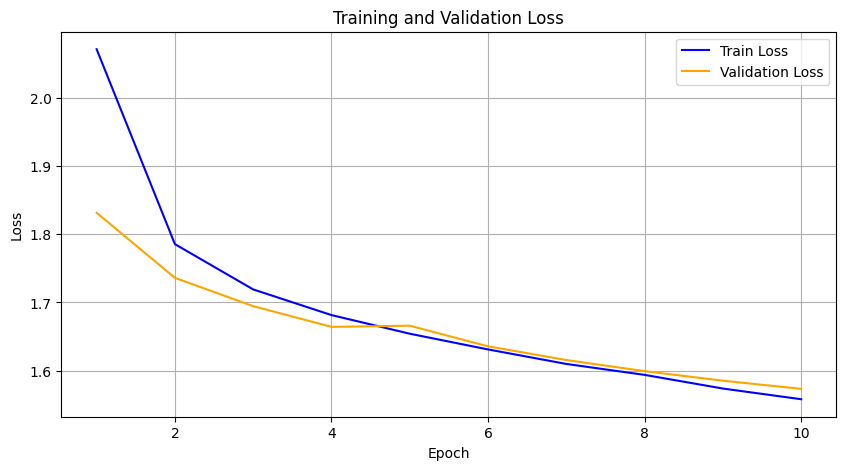

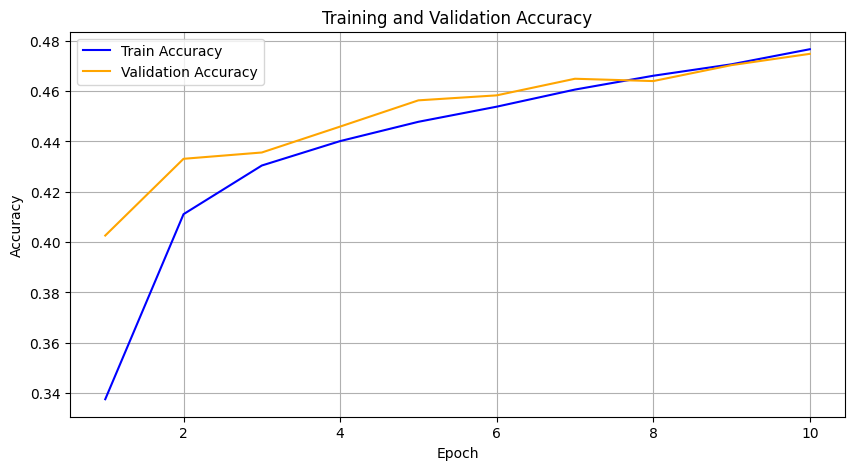

In [26]:
model3 = StyleResNet50_2(prob=0.1)
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model3, 'model_50_2_batch_128', train_loader, val_loader, device, num_epochs = 10, clip_gradient=None)

100%|██████████| 474/474 [03:46<00:00,  2.09it/s]


Epoch [1/10], Step [474/474], Training Loss: 2.1526, Training Accuracy: 0.3068, Validation Loss: 1.8686, Validation Accuracy: 0.3907


100%|██████████| 474/474 [03:47<00:00,  2.08it/s]


Epoch [2/10], Step [474/474], Training Loss: 1.8659, Training Accuracy: 0.3871, Validation Loss: 1.7587, Validation Accuracy: 0.4276


100%|██████████| 474/474 [04:02<00:00,  1.95it/s]


Epoch [3/10], Step [474/474], Training Loss: 1.7973, Training Accuracy: 0.4067, Validation Loss: 1.7202, Validation Accuracy: 0.4388


100%|██████████| 474/474 [03:53<00:00,  2.03it/s]


Epoch [4/10], Step [474/474], Training Loss: 1.7614, Training Accuracy: 0.4158, Validation Loss: 1.6856, Validation Accuracy: 0.4443


100%|██████████| 474/474 [04:02<00:00,  1.95it/s]


Epoch [5/10], Step [474/474], Training Loss: 1.7332, Training Accuracy: 0.4225, Validation Loss: 1.6672, Validation Accuracy: 0.4517


100%|██████████| 474/474 [04:02<00:00,  1.96it/s]


Epoch [6/10], Step [474/474], Training Loss: 1.7090, Training Accuracy: 0.4284, Validation Loss: 1.6479, Validation Accuracy: 0.4534


100%|██████████| 474/474 [03:56<00:00,  2.01it/s]


Epoch [7/10], Step [474/474], Training Loss: 1.6935, Training Accuracy: 0.4327, Validation Loss: 1.6357, Validation Accuracy: 0.4600


100%|██████████| 474/474 [03:34<00:00,  2.21it/s]


Epoch [8/10], Step [474/474], Training Loss: 1.6815, Training Accuracy: 0.4384, Validation Loss: 1.6255, Validation Accuracy: 0.4608


100%|██████████| 474/474 [04:06<00:00,  1.92it/s]


Epoch [9/10], Step [474/474], Training Loss: 1.6665, Training Accuracy: 0.4421, Validation Loss: 1.6075, Validation Accuracy: 0.4689


100%|██████████| 474/474 [04:07<00:00,  1.92it/s]


Epoch [10/10], Step [474/474], Training Loss: 1.6515, Training Accuracy: 0.4468, Validation Loss: 1.6036, Validation Accuracy: 0.4623
elapsed time: 2672.293226957321


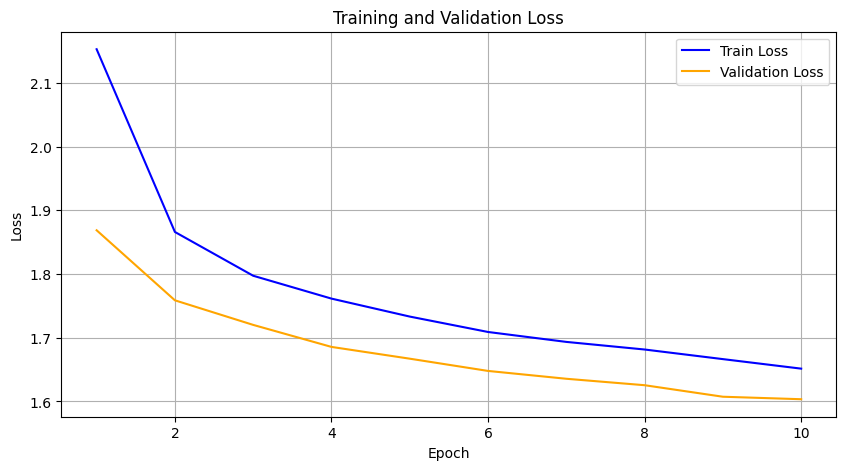

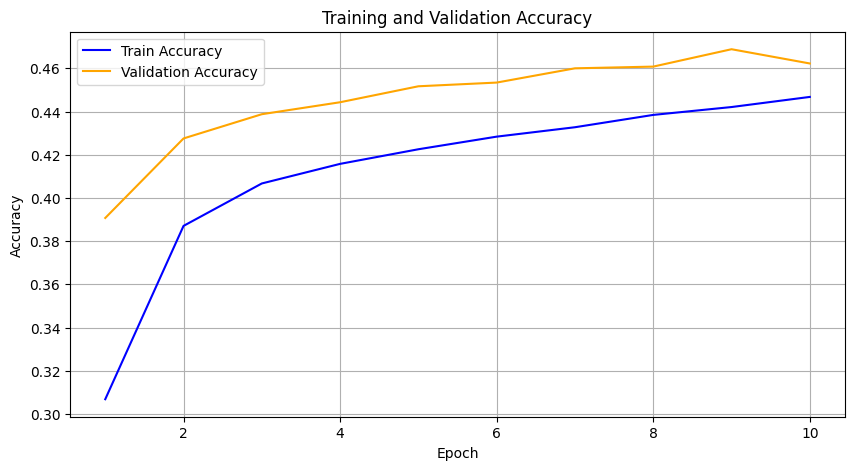

In [28]:
model4 = StyleResNet50_2(prob=0.3)
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model4, 'model_50_4_batch_128', train_loader, val_loader, device, num_epochs = 10, clip_gradient=None)

100%|██████████| 474/474 [03:43<00:00,  2.12it/s]


Epoch [1/10], Step [474/474], Training Loss: 1.5445, Training Accuracy: 0.4795, Validation Loss: 1.5689, Validation Accuracy: 0.4753


100%|██████████| 474/474 [03:50<00:00,  2.06it/s]


Epoch [2/10], Step [474/474], Training Loss: 1.5298, Training Accuracy: 0.4842, Validation Loss: 1.5494, Validation Accuracy: 0.4835


100%|██████████| 474/474 [03:57<00:00,  2.00it/s]


Epoch [3/10], Step [474/474], Training Loss: 1.5155, Training Accuracy: 0.4888, Validation Loss: 1.5519, Validation Accuracy: 0.4792


100%|██████████| 474/474 [04:02<00:00,  1.96it/s]


Epoch [4/10], Step [474/474], Training Loss: 1.4979, Training Accuracy: 0.4933, Validation Loss: 1.5422, Validation Accuracy: 0.4809


100%|██████████| 474/474 [04:03<00:00,  1.95it/s]


Epoch [5/10], Step [474/474], Training Loss: 1.4866, Training Accuracy: 0.4984, Validation Loss: 1.5270, Validation Accuracy: 0.4916


100%|██████████| 474/474 [04:02<00:00,  1.95it/s]


Epoch [6/10], Step [474/474], Training Loss: 1.4704, Training Accuracy: 0.5035, Validation Loss: 1.5178, Validation Accuracy: 0.4916


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [7/10], Step [474/474], Training Loss: 1.4563, Training Accuracy: 0.5076, Validation Loss: 1.5192, Validation Accuracy: 0.4943


100%|██████████| 474/474 [04:05<00:00,  1.93it/s]


Epoch [8/10], Step [474/474], Training Loss: 1.4451, Training Accuracy: 0.5116, Validation Loss: 1.5071, Validation Accuracy: 0.4914


100%|██████████| 474/474 [04:00<00:00,  1.97it/s]


Epoch [9/10], Step [474/474], Training Loss: 1.4306, Training Accuracy: 0.5160, Validation Loss: 1.4989, Validation Accuracy: 0.4954


100%|██████████| 474/474 [04:18<00:00,  1.83it/s]


Epoch [10/10], Step [474/474], Training Loss: 1.4193, Training Accuracy: 0.5200, Validation Loss: 1.4988, Validation Accuracy: 0.4920
elapsed time: 2725.271726131439


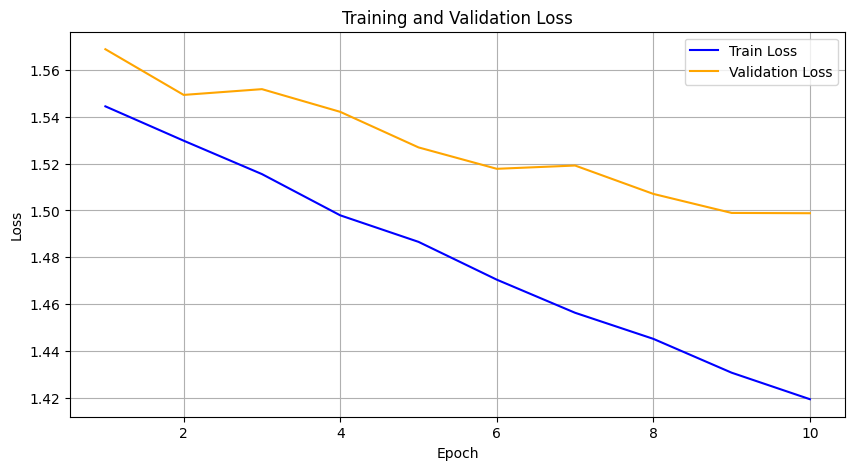

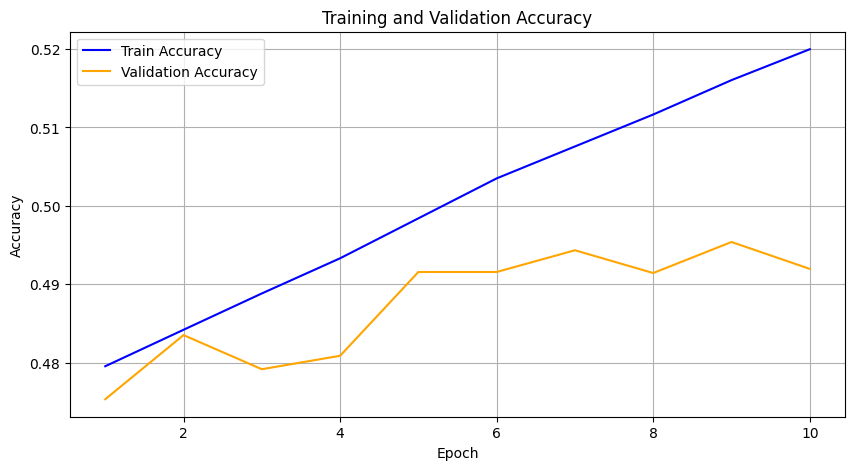

In [30]:
model_best = joblib.load('C:\\Users\\anson\\Documents\\Projects\\Python\\AI_Art_Curation_System\\outputs\\model_50_2_batch_128_epoch10.joblib')
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model_best, 'model_50_2_batch_128_p2', train_loader, val_loader, device, num_epochs = 10, clip_gradient=None)

Batch Size Invariance

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anson\Documents\Projects\Python\AI_Art_Curation_System\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 474/474 [04:49<00:00,  1.64it/s]


Epoch [1/5], Step [474/474], Training Loss: 2.2695, Training Accuracy: 0.2749, Validation Loss: 1.9462, Validation Accuracy: 0.3820


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [2/5], Step [474/474], Training Loss: 1.9838, Training Accuracy: 0.3518, Validation Loss: 1.8213, Validation Accuracy: 0.4087


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [3/5], Step [474/474], Training Loss: 1.9122, Training Accuracy: 0.3704, Validation Loss: 1.7732, Validation Accuracy: 0.4215


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [4/5], Step [474/474], Training Loss: 1.8738, Training Accuracy: 0.3800, Validation Loss: 1.7383, Validation Accuracy: 0.4314


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [5/5], Step [474/474], Training Loss: 1.8428, Training Accuracy: 0.3890, Validation Loss: 1.7158, Validation Accuracy: 0.4434
elapsed time: 1397.29403591156


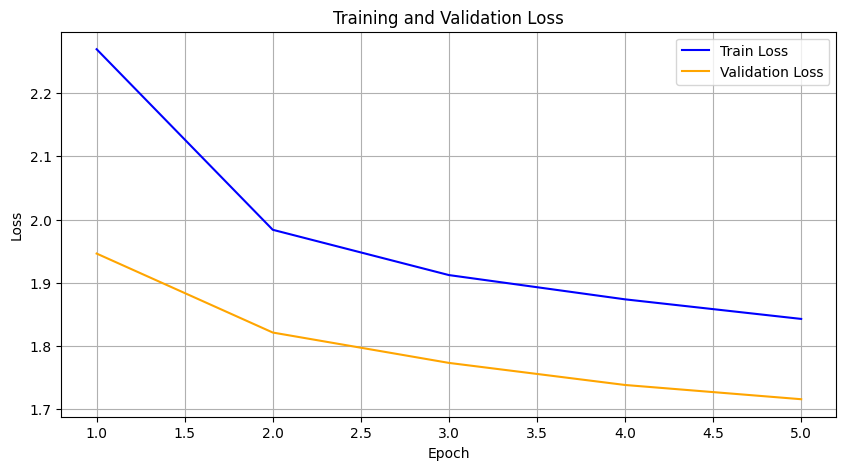

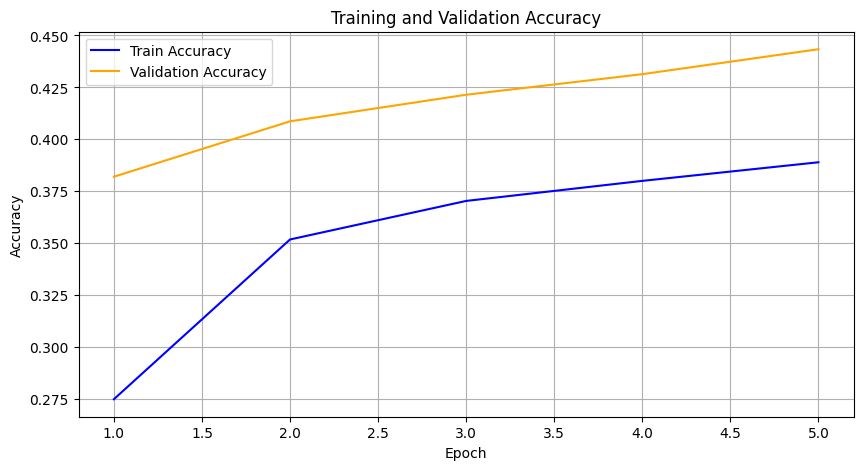

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [1/5], Step [474/474], Training Loss: 2.2729, Training Accuracy: 0.2738, Validation Loss: 1.9490, Validation Accuracy: 0.3711


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [2/5], Step [474/474], Training Loss: 1.9896, Training Accuracy: 0.3497, Validation Loss: 1.8189, Validation Accuracy: 0.4177


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [3/5], Step [474/474], Training Loss: 1.9124, Training Accuracy: 0.3709, Validation Loss: 1.7774, Validation Accuracy: 0.4204


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [4/5], Step [474/474], Training Loss: 1.8673, Training Accuracy: 0.3827, Validation Loss: 1.7457, Validation Accuracy: 0.4270


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [5/5], Step [474/474], Training Loss: 1.8481, Training Accuracy: 0.3879, Validation Loss: 1.7223, Validation Accuracy: 0.4336
elapsed time: 1335.8488094806671


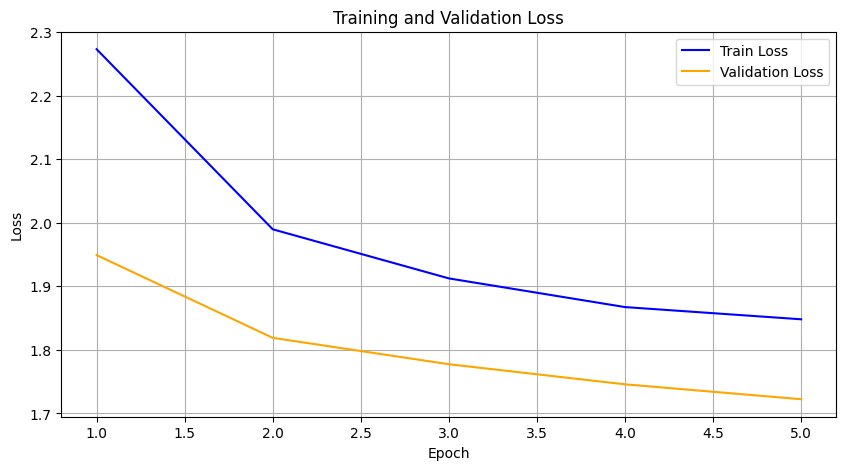

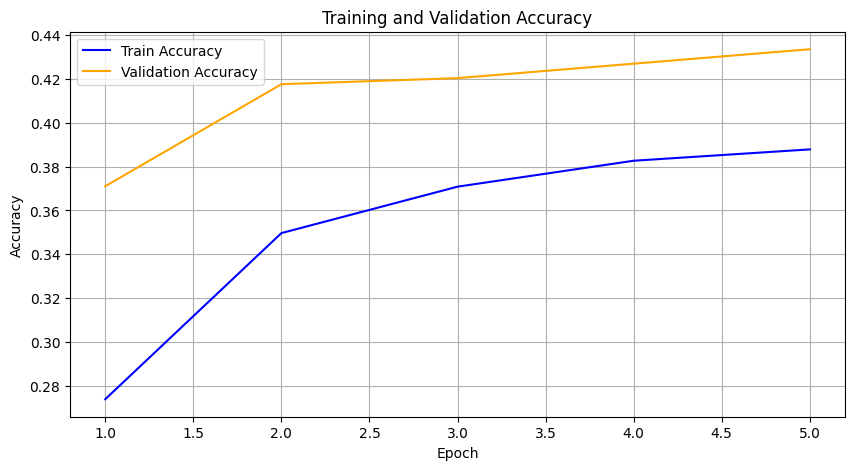

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [1/5], Step [474/474], Training Loss: 2.2731, Training Accuracy: 0.2725, Validation Loss: 1.9510, Validation Accuracy: 0.3728


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [2/5], Step [474/474], Training Loss: 1.9858, Training Accuracy: 0.3512, Validation Loss: 1.8232, Validation Accuracy: 0.4112


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [3/5], Step [474/474], Training Loss: 1.9111, Training Accuracy: 0.3698, Validation Loss: 1.7709, Validation Accuracy: 0.4289


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [4/5], Step [474/474], Training Loss: 1.8758, Training Accuracy: 0.3812, Validation Loss: 1.7478, Validation Accuracy: 0.4302


100%|██████████| 474/474 [03:55<00:00,  2.02it/s]


Epoch [5/5], Step [474/474], Training Loss: 1.8466, Training Accuracy: 0.3886, Validation Loss: 1.7170, Validation Accuracy: 0.4348
elapsed time: 1333.5166323184967


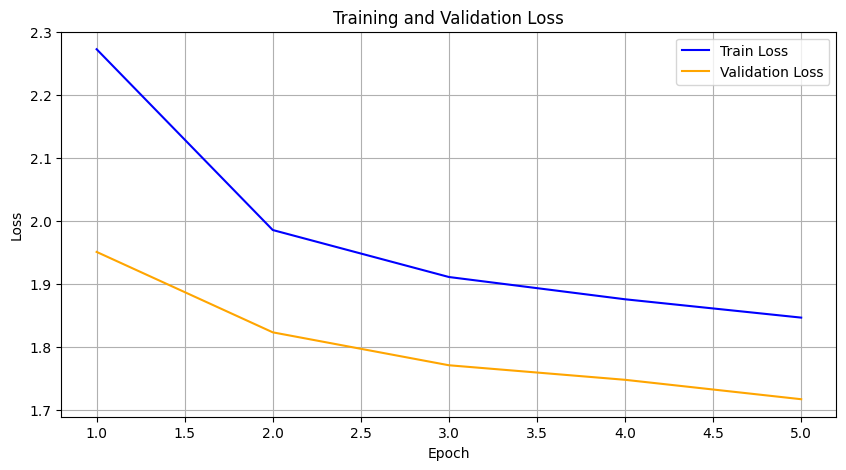

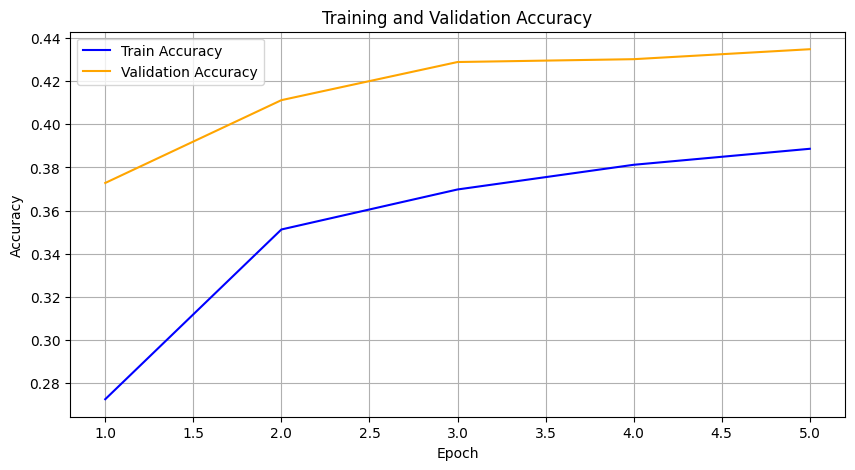

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


100%|██████████| 474/474 [03:54<00:00,  2.02it/s]


Epoch [1/5], Step [474/474], Training Loss: 2.2645, Training Accuracy: 0.2783, Validation Loss: 1.9422, Validation Accuracy: 0.3686


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [2/5], Step [474/474], Training Loss: 1.9796, Training Accuracy: 0.3538, Validation Loss: 1.8233, Validation Accuracy: 0.4125


100%|██████████| 474/474 [03:55<00:00,  2.02it/s]


Epoch [3/5], Step [474/474], Training Loss: 1.9047, Training Accuracy: 0.3749, Validation Loss: 1.7704, Validation Accuracy: 0.4281


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [4/5], Step [474/474], Training Loss: 1.8673, Training Accuracy: 0.3831, Validation Loss: 1.7452, Validation Accuracy: 0.4322


100%|██████████| 474/474 [03:55<00:00,  2.02it/s]


Epoch [5/5], Step [474/474], Training Loss: 1.8428, Training Accuracy: 0.3891, Validation Loss: 1.7258, Validation Accuracy: 0.4364
elapsed time: 1332.2413182258606


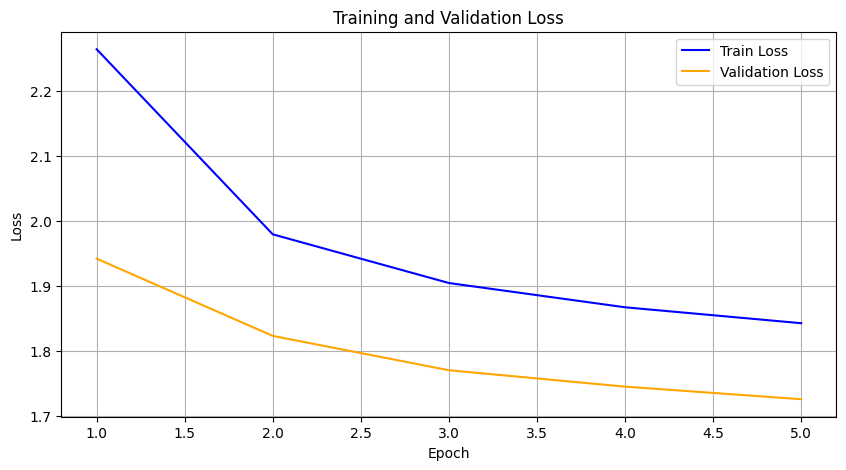

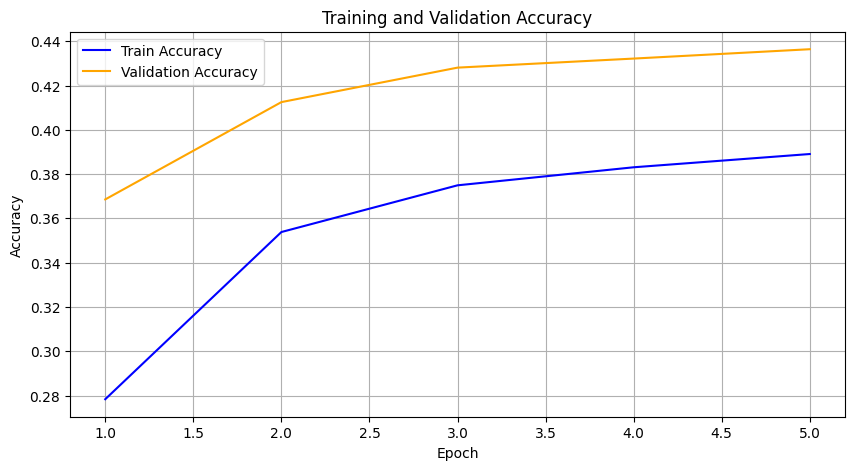

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


100%|██████████| 474/474 [03:54<00:00,  2.02it/s]


Epoch [1/5], Step [474/474], Training Loss: 2.2681, Training Accuracy: 0.2759, Validation Loss: 1.9353, Validation Accuracy: 0.3847


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [2/5], Step [474/474], Training Loss: 1.9822, Training Accuracy: 0.3525, Validation Loss: 1.8193, Validation Accuracy: 0.4083


100%|██████████| 474/474 [03:55<00:00,  2.02it/s]


Epoch [3/5], Step [474/474], Training Loss: 1.9123, Training Accuracy: 0.3715, Validation Loss: 1.7749, Validation Accuracy: 0.4265


100%|██████████| 474/474 [03:55<00:00,  2.02it/s]


Epoch [4/5], Step [474/474], Training Loss: 1.8684, Training Accuracy: 0.3840, Validation Loss: 1.7417, Validation Accuracy: 0.4377


100%|██████████| 474/474 [03:55<00:00,  2.02it/s]


Epoch [5/5], Step [474/474], Training Loss: 1.8471, Training Accuracy: 0.3867, Validation Loss: 1.7262, Validation Accuracy: 0.4360
elapsed time: 1332.1008472442627


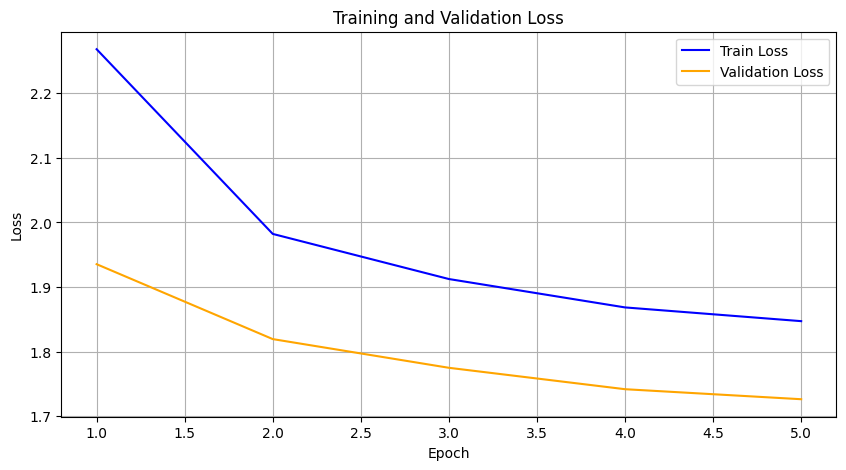

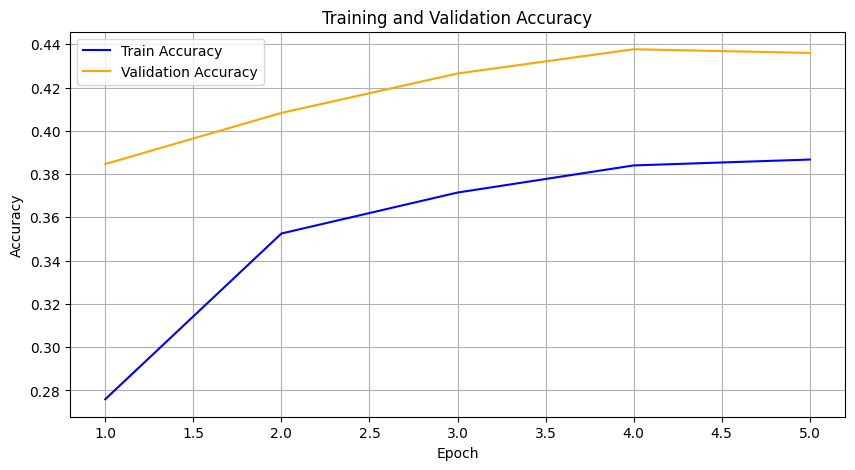

Dataset ImageFolder
    Number of datapoints: 75788
    Root location: E:/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Number of classes: 19
data loading completed


100%|██████████| 474/474 [03:54<00:00,  2.02it/s]


Epoch [1/5], Step [474/474], Training Loss: 2.2725, Training Accuracy: 0.2748, Validation Loss: 1.9416, Validation Accuracy: 0.3752


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [2/5], Step [474/474], Training Loss: 1.9843, Training Accuracy: 0.3538, Validation Loss: 1.8220, Validation Accuracy: 0.4155


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [3/5], Step [474/474], Training Loss: 1.9102, Training Accuracy: 0.3720, Validation Loss: 1.7736, Validation Accuracy: 0.4194


100%|██████████| 474/474 [03:55<00:00,  2.02it/s]


Epoch [4/5], Step [474/474], Training Loss: 1.8672, Training Accuracy: 0.3852, Validation Loss: 1.7435, Validation Accuracy: 0.4247


100%|██████████| 474/474 [03:55<00:00,  2.01it/s]


Epoch [5/5], Step [474/474], Training Loss: 1.8445, Training Accuracy: 0.3891, Validation Loss: 1.7272, Validation Accuracy: 0.4380
elapsed time: 1332.5882244110107


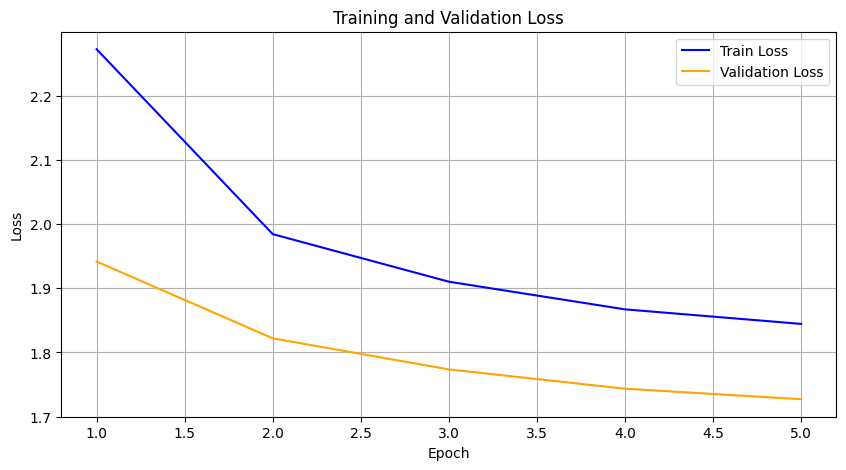

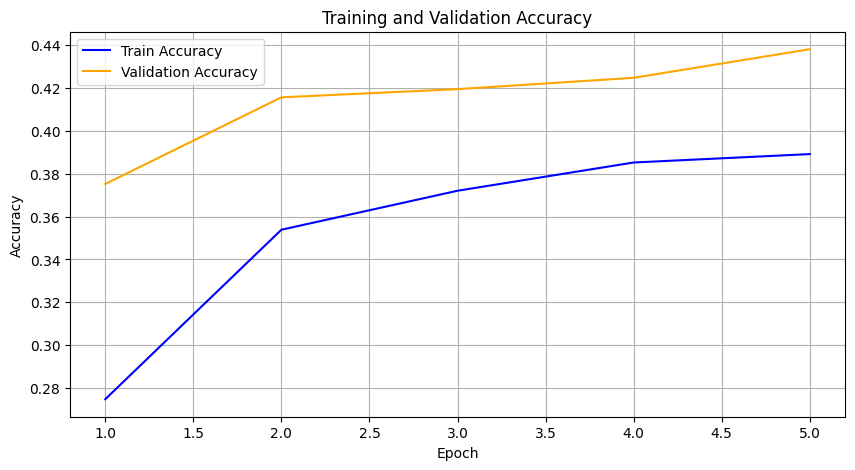

In [14]:
#Batch size
batchsizes=[16,32,64,128,256,512]
for i in range(len(batchsizes)):
    train_loader, val_loader, test_loader = custom_dataloader(unzipped_dir, transform, batch_size=128)
    model = StyleResNet50_2()
    trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, f'model_50_2_bs_{i}', train_loader, val_loader, device, num_epochs = 5, clip_gradient=None)

In [15]:
#Load saved results (batch size)
combined_data = pd.DataFrame()
for i in range(len(batchsizes)):
    data = pd.read_csv(f'C:\\Users\\anson\\Documents\\Projects\\Python\\AI_Art_Curation_System\\batch\\model_50_2_bs_{i}_results.csv')
    data['batch_size'] = batchsizes[i]
    # Concatenate the data
    combined_data = pd.concat([combined_data, data], ignore_index=True)
combined_data.to_csv('combined_results.csv', index=False)

## Results of Hyperparameter Tuning

- Batch Size: Invariant, higher batch size preferred for faster training at least until 512
- Learning Rate: Must be kept low, below 0.0001
    - Scheduling: Was not viable since only run for few epochs
- Epochs: Train for 20 epochs and use early stopping (Note: Only 5 used for tuning)
- Dropout: Lower dropout is preferred (only 1 needed) (0.1 is best, >0.3 is too much)
- Gradient Clipping: Unnecessary since we don't see exploding gradients, but if used use below 1.0
- Weight Decay: l2 weight decay is unnecessary, if used use very small amount 0.01
- FC Layers
    - 1 layer: Insufficient, not enough capacity
    - 2 layer: Sufficient capacity
    - 3 layer: Sufficient capacity, overfitting is extensive
- Leaky ReLu used over ReLu

Note: ResNet50 weights were frozen, but were not pre-computed. Pre-computing the weights will significantly speed up training and also increase the effect of batch size on reducing training time. Current training takes 3-10 minutes per epoch.

### Future Work
Overfitting is a large issue with our model, so data augmentation can help with this. Dropping more classes (19 to 13) improves the model performance, but also worsens the overfitting problem. 

## ResNet Fine-Tuning
ResNet50 finetuning takes 1h42min per epoch. If attempted try to  [freeze batch norm layers](https://myrtle.ai/learn/how-to-train-your-resnet-3-regularisation/), [warm start](https://www.researchgate.net/figure/A-comparison-between-ResNet-models-trained-using-warm-start-random-initialization-and_fig4_369380212), etc.